In [21]:
# pip install requests pandas ccxt alpha-vantage==3.0.0 matplotlib seaborn
import os
import ccxt
import pandas as pd
import numpy as np
from datetime import datetime
from functools import reduce
from alpha_vantage.foreignexchange import ForeignExchange
from alpha_vantage.timeseries import TimeSeries
from datetime import datetime
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

## Configs

In [15]:
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
pd.options.display.float_format = '{:.2f}'.format

In [22]:
# === 기본 설정 ===
BASE_DIR = os.getcwd()
DATA_DIR = os.path.join(BASE_DIR, "data")
TODAY = datetime.now().strftime("%Y-%m-%d") # end_date 제한용

# === 경로 설정 ===
PATHS = {
    'merged': os.path.join(DATA_DIR, '01_merged_data.csv'),               # 병합된 원본 데이터
    'missing_handled': os.path.join(DATA_DIR, '02_missing_handled.csv'),  # 결측값 처리 완료본
    'alternative': os.path.join(DATA_DIR, '03_alternative_added.csv'),    # 대체 지표 추가 완료본
    'normalized': os.path.join(DATA_DIR, '04_normalized.csv'),            # 정규화 완료본
    'correlation': os.path.join(DATA_DIR, '05_correlation.csv'),          # 상관관계 분석 결과
}

# === 실행 파라미터 ===
config = {
    'start_date': '2023-01-01',
    'end_date': TODAY,  # 오늘 날짜로 자동 제한
    'api_key': 'LB15G5QAECM4H5M7',
    'save_csv': True,
    'base_dir': BASE_DIR,
    'data_dir': DATA_DIR,
    'paths': PATHS  # 경로 dict 자체를 포함시켜 사용 편의성 확보
}

## CCXT API 데이터 수집 함수 정의

In [23]:
def get_ccxt_data(exchange_name, base, quote, **config):
    """
    CCXT를 사용하여 암호화폐 또는 Forex 데이터를 수집하는 함수

    Parameters:
    - exchange_name: 거래소 이름 (예: 'kraken', 'binance')
    - base: 기준 통화 (예: 'BTC', 'USD')
    - quote: 상대 통화 (예: 'USD', 'EUR')
    - **config: 공통 설정값 (start_date, end_date, save_csv, data_dir 등)

    Returns:
    - pandas DataFrame with renamed close and volume columns
    """ 
    try:
        start_date = config.get('start_date', '2023-01-01')
        end_date = config.get('end_date', TODAY)
        save_csv = config.get('save_csv', True)
        output_dir = config.get('data_dir', BASE_DIR)

        exchange_class = getattr(ccxt, exchange_name.lower())
        exchange_instance = exchange_class()
        exchange_instance.load_markets()

        symbol = f"{base}/{quote}"
        if symbol not in exchange_instance.symbols:
            raise ValueError(f"{symbol}은(는) {exchange_name}에서 지원되지 않습니다.")
        
        timeframe = '1d'
        since = int(pd.to_datetime(start_date).timestamp() * 1000)
        end_ts = int(pd.to_datetime(end_date).timestamp() * 1000)
        all_data = []
        
        while since < end_ts:
            candles = exchange_instance.fetch_ohlcv(symbol, timeframe, since=since, limit=215)
            if not candles:
                break
            all_data.extend(candles)
            since = candles[-1][0] + 86400000   # 하루 단위(ms)
        
        if not all_data:
            print(f"{exchange_name} {symbol} 데이터 수집 실패")
            return None        
        
        df = pd.DataFrame(all_data, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
        df = df.set_index('timestamp')[['close', 'volume']]
        df = df.rename(columns={'close': f'{base}_{quote}', 'volume': f'{base}_Volume'})
        df = df.loc[start_date:end_date]

        if save_csv:
            filename = f"{exchange_name}_{base}_{quote}.csv"
            csv_file = os.path.join(output_dir, filename)
            df.to_csv(csv_file, encoding='utf-8')
            print(f"{exchange_name} {base}/{quote} 데이터 크기: {df.shape}, 저장: {csv_file}")
        
        return df

    except Exception as e:
        print(f"get_ccxt_data({exchange_name}, {base}/{quote}) 오류: {e}")
        return None

## Alpha Vantage API 데이터 수집 함수 정의

In [24]:
# === 공통 후처리 헬퍼 함수 정의 ===
def _process_alpha_vantage_data(df, column_name, filename, **config):
    start_date = config['start_date']
    end_date = min(pd.to_datetime(config['end_date']), pd.to_datetime(datetime.now().date()))
    output_dir = config.get('data_dir', BASE_DIR)
    save_csv = config.get('save_csv', True)

    df = df[['4. close']].rename(columns={'4. close': column_name})
    df.index = pd.to_datetime(df.index)
    df = df.sort_index()
    df = df.loc[start_date:end_date]

    if save_csv:
        path = os.path.join(output_dir, filename)
        df.to_csv(path, encoding='utf-8')
        print(f"[Saved] {filename} -> {df.shape}")

    return df


# === Forex ===
def get_alpha_vantage_forex_data(base, quote, **config):
    try:
        api_key = config['api_key']
        forex = ForeignExchange(key=api_key, output_format='pandas')
        data, _ = forex.get_currency_exchange_daily(
            from_symbol=base, to_symbol=quote, outputsize='full'
        )
        filename = f"alpha_vantage_{base}_{quote}.csv"
        return _process_alpha_vantage_data(data, f"{base}_{quote}", filename, **config)
    except Exception as e:
        print(f"[ERROR] get_alpha_vantage_forex_data({base}/{quote}): {e}")
        return None


# === Gold ===
def get_alpha_vantage_gold_data(**config):
    try:
        api_key = config['api_key']
        ts = TimeSeries(key=api_key, output_format='pandas')
        data, _ = ts.get_daily(symbol='XAUUSD', outputsize='full')
        return _process_alpha_vantage_data(data, "XAU_USD", "alpha_vantage_XAU_USD.csv", **config)
    except Exception as e:
        print(f"[ERROR] get_alpha_vantage_gold_data: {e}")
        return None

## 데이터 수집 및 통합 함수

In [ ]:
# === 데이터 수집 ===
def collect_crypto_forex_data(**config):
    try:
        start_date = config['start_date']
        end_date = min(pd.to_datetime(config['end_date']), pd.to_datetime(datetime.now().date()))
        config['end_date'] = end_date
        print(f"[INFO] 데이터 수집 시작({start_date}~{end_date})")
    
        # 수집 대상 정의
        crypto_pairs = [
            ('kraken', 'BTC', 'USD'),
            ('binance', 'BTC', 'EUR'),
            ('binance', 'BTC', 'KRW'),
            ('bithumb', 'BTC', 'KRW'),
        ]

        forex_pairs = [
            ('USD', 'EUR'),
            ('USD', 'JPY'),
            ('USD', 'CNY'),
            ('USD', 'KRW'),
        ]

        # 수집 실행
        crypto_dfs = [get_ccxt_data(ex, base, quote, **config) for ex, base, quote in crypto_pairs]
        forex_dfs = [get_alpha_vantage_forex_data(base, quote, **config) for base, quote in forex_pairs]
        gold_df = [get_alpha_vantage_gold_data(**config)]

        # 유효한 데이터만 병함
        all_dfs = [df for df in (crypto_dfs + forex_dfs + gold_df) if df is not None]

        if not all_dfs:
            raise ValueError("[ERROR] 수집된 유효한 데이터가 없습니다.")

        # 날짜 기준으로 병합
        merged = reduce(lambda left, right: pd.merge(left, right, on='date', how='outer'), all_dfs)
        print(f"통합 데이터 크기: {merged.shape}")

        # 결측값 조회
        print(merged.isnull().sum())

        # 결측값 처리
        merged = merged.dropna()
        print(f"결측값 처리 후 데이터 크기: {merged.shape}")

        # 저장
        if config.get('save_csv', True):
            merged_path = config['paths']['merged']
            merged.to_csv(merged_path, encoding='utf-8')
            print(f"저장 완료: {merged_path}")

        return merged

    except Exception as e:
        print(f"[ERROR] collect_crypto_forex_data: {e}")
        return None

In [26]:
merged_data = collect_crypto_forex_data(**config)

[INFO] 데이터 수집 시작(2023-01-01~2025-07-31 00:00:00)
kraken BTC/USD 데이터 크기: (720, 2), 저장: c:\workspace\hit_ml_dl\practice\bitcoin\data\kraken_BTC_USD.csv
binance BTC/EUR 데이터 크기: (943, 2), 저장: c:\workspace\hit_ml_dl\practice\bitcoin\data\binance_BTC_EUR.csv
get_ccxt_data(binance, BTC/KRW) 오류: BTC/KRW은(는) binance에서 지원되지 않습니다.
bithumb BTC/KRW 데이터 크기: (942, 2), 저장: c:\workspace\hit_ml_dl\practice\bitcoin\data\bithumb_BTC_KRW.csv
[ERROR] get_alpha_vantage_forex_data(USD/EUR): We have detected your API key as LB15G5QAECM4H5M7 and our standard API rate limit is 25 requests per day. Please subscribe to any of the premium plans at https://www.alphavantage.co/premium/ to instantly remove all daily rate limits.
[ERROR] get_alpha_vantage_forex_data(USD/JPY): We have detected your API key as LB15G5QAECM4H5M7 and our standard API rate limit is 25 requests per day. Please subscribe to any of the premium plans at https://www.alphavantage.co/premium/ to instantly remove all daily rate limits.
[ERROR] get_a

In [28]:
def merge_all_csv_files_in_dir(data_dir, output_filename='merged_data_temp.csv'):
    """
    주어진 디렉토리 내 모든 CSV 파일을 날짜 기준으로 병합하여 저장합니다.
    """
    try:
        csv_files = [f for f in os.listdir(data_dir) if f.endswith('.csv')]
        if not csv_files:
            raise FileNotFoundError(f"[WARN] '{data_dir}' 폴더에 CSV 파일이 없습니다.")

        dfs = []
        for file in csv_files:
            file_path = os.path.join(data_dir, file)
            df = pd.read_csv(file_path, index_col=0, parse_dates=True)
            dfs.append(df)

        merged_df = pd.concat(dfs, axis=1, join='inner')  # 날짜 기준 inner 병합
        output_path = os.path.join(data_dir, output_filename)
        merged_df.to_csv(output_path, encoding='utf-8')

        print(f"[OK] CSV 병합 완료: {merged_df.shape}, 저장: {output_path}")
        return merged_df

    except Exception as e:
        print(f"[ERROR] merge_all_csv_files_in_dir: {e}")
        return None

merged_df = merge_all_csv_files_in_dir(config['data_dir'])

[OK] CSV 병합 완료: (0, 141), 저장: c:\workspace\hit_ml_dl\practice\bitcoin\data\merged_data_temp.csv


## 기술 지표 생성

In [114]:
# 지표 계산 함수들
def calculate_rsi(prices, window=14):
    """RSI 계산"""
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_bollinger_bands(prices, window=20, num_std=2):
    """볼린저 밴드 계산"""
    rolling_mean = prices.rolling(window=window).mean()
    rolling_std = prices.rolling(window=window).std()
    
    upper_band = rolling_mean + (rolling_std * num_std)
    lower_band = rolling_mean - (rolling_std * num_std)
    bb_percent = (prices - lower_band) / (upper_band - lower_band)
    
    return rolling_mean, upper_band, lower_band, bb_percent

def calculate_moving_averages(prices):
    """이동평균 계산"""
    ma_20 = prices.rolling(window=20).mean()
    ma_50 = prices.rolling(window=50).mean()
    return ma_20, ma_50

def calculate_volume_indicators(df):
    """거래량 지표 계산"""
    # 거래량 이동평균 비율
    vol_ma_20 = df['volume'].rolling(window=20).mean()
    vol_ratio = df['volume'] / vol_ma_20
    
    # 가격-거래량 상관관계 (20일 롤링)
    price_vol_corr = df['close'].rolling(window=20).corr(df['volume'])
    
    return vol_ratio, price_vol_corr

In [ ]:
# 1순위 구현사항
# 로그 수익률: np.log(close / close.shift(1))
# RSI (14일): 과매수/과매도 신호
# 볼린저 밴드: %B 지표로 변환
# 이동평균 비율: MA20/MA50 비율

# 2순위 구현사항
# StandardScaler
# 거래량 지표: 거래량 비율, 가격-거래량 상관관계
print(os.getcwd())
BEFORE_FEATURE_PATH = BASE_DIR + "/data/" + "merged_data.csv"
AFTER_FEATURE_PATH = BASE_DIR + "/data/" + "merged_data_features.csv"

# 1. 데이터 로드 및 전처리
def load_and_clean_data():
    df = pd.read_csv(BEFORE_FEATURE_PATH, encoding='utf-8')
    df['date'] = pd.to_datetime(df.iloc[:, 0])
    df['btc_usd'] = df['BTC_EUR'] / df['USD_EUR']

    base_data = df[['date', 'btc_usd', 'BTC_Volume']].copy()
    base_data.columns = ['date', 'price', 'volume']
    base_data = base_data.dropna().reset_index(drop=True)
    
    print(f"데이터 기간: {base_data['date'].min()} ~ {base_data['date'].max()}")
    print(f"총 {len(base_data)}일 데이터")
   
    return df, base_data

# 2. 핵심 기술지표 생성 (1순위만)
def create_core_features(df):
    data = df.copy()

    # log return
    if 'log_returns' not in data.columns:
        data['log_returns'] = np.log(data['price'] / data['price'].shift(1))

    # RSI (14)
    if 'rsi' not in data.columns:
        delta = data['price'].diff()
        gain = delta.where(delta > 0, 0).rolling(14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
        rs = gain / loss
        data['rsi'] = 100 - (100 / (1 + rs))

    # 볼린저 밴드 %B
    if 'bb_percent' not in data.columns:
        ma20 = data['price'].rolling(20).mean()
        std20 = data['price'].rolling(20).std()
        data['bb_percent'] = (data['price'] - (ma20 - 2 * std20)) / (4 * std20)

    # 이동평균 비율
    if 'ma_ratio' not in data.columns:
        ma20 = data['price'].rolling(20).mean()
        ma50 = data['price'].rolling(50).mean()
        data['ma_ratio'] = ma20 / ma50

    # 거래량 비율
    if 'vol_ratio' not in data.columns:
        vol_ma = data['volume'].rolling(20).mean()
        data['vol_ratio'] = data['volume'] / vol_ma

    # 결측치 제거
    print(data.isnull().sum().to_string())
    data = data.dropna().reset_index(drop=True)

    # 저장
    data.to_csv(AFTER_FEATURE_PATH, index=False, encoding='utf-8')
    return data

# 3. 원본 CSV에 기술지표 컬럼 추가
def update_original_csv(original_df, features_df):
    feature_columns = ['log_returns', 'rsi', 'bb_percent', 'ma_ratio', 'vol_ratio', 'price_vol_corr']
    original_df['date'] = pd.to_datetime(original_df.iloc[:, 0])
    
    for col in feature_columns:
        if col in features_df.columns:
            merge_data = features_df[['date', col]].copy()
            original_df = original_df.merge(merge_data, on='date', how='left')
    
    original_df.to_csv(AFTER_FEATURE_PATH, index=False)
    print(f"merged_data_updated.csv 저장 완료: {original_df.shape}")
    print(f"추가된 컬럼: {feature_columns}")
    
    return original_df

c:\workspace\hit_ml_dl\practice


In [120]:
# 결측값 제거
def handle_missing_values(df):
    data = df.copy()
    original_length = len(data)

    # 1. 로그 수익률 (1개 결측) - 제거 (계산 불가능)
    if 'log_returns' in data.columns:
        data = data.dropna(subset=['log_returns'])
        
    # 2. RSI (13개 결측) - 부분 채우기 + 제거
    if 'rsi' in data.columns:
        # RSI가 계산되기 시작하는 시점부터 유효한 데이터로 간주
        # 처음 10개는 제거하고, 나머지는 전진 채우기
        rsi_start_idx = data['rsi'].first_valid_index()
        if rsi_start_idx is not None and rsi_start_idx > 10:
            data = data.iloc[10:].reset_index(drop=True)
            data['rsi'] = data['rsi'].fillna(method='ffill')

    # 3. 볼린저 밴드 (19개 결측) - 이동평균으로 추정
    if 'bb_percent' in data.columns:
        bb_missing_mask = data['bb_percent'].isnull()
        data.loc[bb_missing_mask, 'bb_percent'] = 0.5

    # 4. 이동평균 비율 (49개 결측) - 점진적 처리
    if 'ma_ratio' in data.columns:
        ma_missing_mask = data['ma_ratio'].isnull()
        data.loc[ma_missing_mask, 'ma_ratio'] = 1.0
    
    # 5. 거래량 비율 (19개) - 1.0으로 초기화 (중립)
    if 'vol_ratio' in data.columns:
        vol_missing_mask = data['vol_ratio'].isnull()
        data.loc[vol_missing_mask, 'vol_ratio'] = 1.0
    
    # 6. 가격-거래량 상관관계 - 0으로 초기화 (증립)
    if 'price_vol_corr' in data.columns:
        corr_missing_mask = data['price_vol_corr'].isnull()
        data.loc[corr_missing_mask, 'price_vol_corr'] = 0.0

    # 최종 결측값 확인
    final_missing = data.isnull().sum()
    remaining_nulls = final_missing[final_missing > 0]

    if len(remaining_nulls) == 0:
        print("모든 결측값 처리 완료")
    else:
        print("잔여 결측값 존재")
        print(remaining_nulls.isnull().sum())
        data = data.dropna()

    return data

In [121]:
# 4. 상관관계 분석 및 히트맵
def analyze_correlations(df):
    # 분석할 컬럼들 (숫자형만)
    
    print(df.columns())
    numeric_cols = ['log_returns', 'rsi', 'bb_percent', 'ma_ratio', 'vol_ratio', 'price_vol_corr', 'price', 'volume']
    
    # 해당 컬럼들이 존재하는지 확인
    available_cols = [col for col in numeric_cols if col in df.columns]
    print(f"상관관계 분석 대상 컬럼: {available_cols}")
    
    # 상관관계 매트릭스 계산
    corr_matrix = df[available_cols].corr()
    
    # 히트맵 생성
    plt.figure(figsize=(12, 10))
    
    # 상관관계 히트맵
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # 상삼각형 마스크
    sns.heatmap(corr_matrix, 
                annot=True, 
                cmap='coolwarm', 
                center=0,
                square=True,
                fmt='.3f',
                cbar_kws={"shrink": .8})
    
    plt.title('기술지표 상관관계 히트맵', fontsize=16, pad=20)
    plt.tight_layout()
    plt.show()

In [122]:
original_df, base_data = load_and_clean_data()
features_df = create_core_features(base_data)
updated_df = update_original_csv(original_df, features_df)
preprocessed_df = handle_missing_values(updated_df)

데이터 기간: 2024-03-12 00:00:00 ~ 2025-07-30 00:00:00
총 360일 데이터
date            0
price           0
volume          0
log_returns     1
rsi            13
bb_percent     19
ma_ratio       49
vol_ratio      19
merged_data_updated.csv 저장 완료: (360, 58)
추가된 컬럼: ['log_returns', 'rsi', 'bb_percent', 'ma_ratio', 'vol_ratio', 'price_vol_corr']
잔여 결측값 존재
0


In [ ]:
# 상관관계 분석
# analyze_correlations(preprocessed_df)
preprocessed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Unnamed: 0    301 non-null    object        
 1   USD_CNY       301 non-null    float64       
 2   USD_EUR       301 non-null    float64       
 3   USD_JPY       301 non-null    float64       
 4   USD_KRW       301 non-null    float64       
 5   XAU_USD       301 non-null    float64       
 6   BTC_EUR       301 non-null    float64       
 7   BTC_Volume    301 non-null    float64       
 8   BTC_JPY       301 non-null    float64       
 9   BTC_Volume.2  301 non-null    float64       
 10  USD_CNY.1     301 non-null    float64       
 11  USD_EUR.1     301 non-null    float64       
 12  USD_JPY.1     301 non-null    float64       
 13  USD_KRW.1     301 non-null    float64       
 14  XAU_USD.1     301 non-null    float64       
 15  BTC_EUR.1     301 non-null    float64   

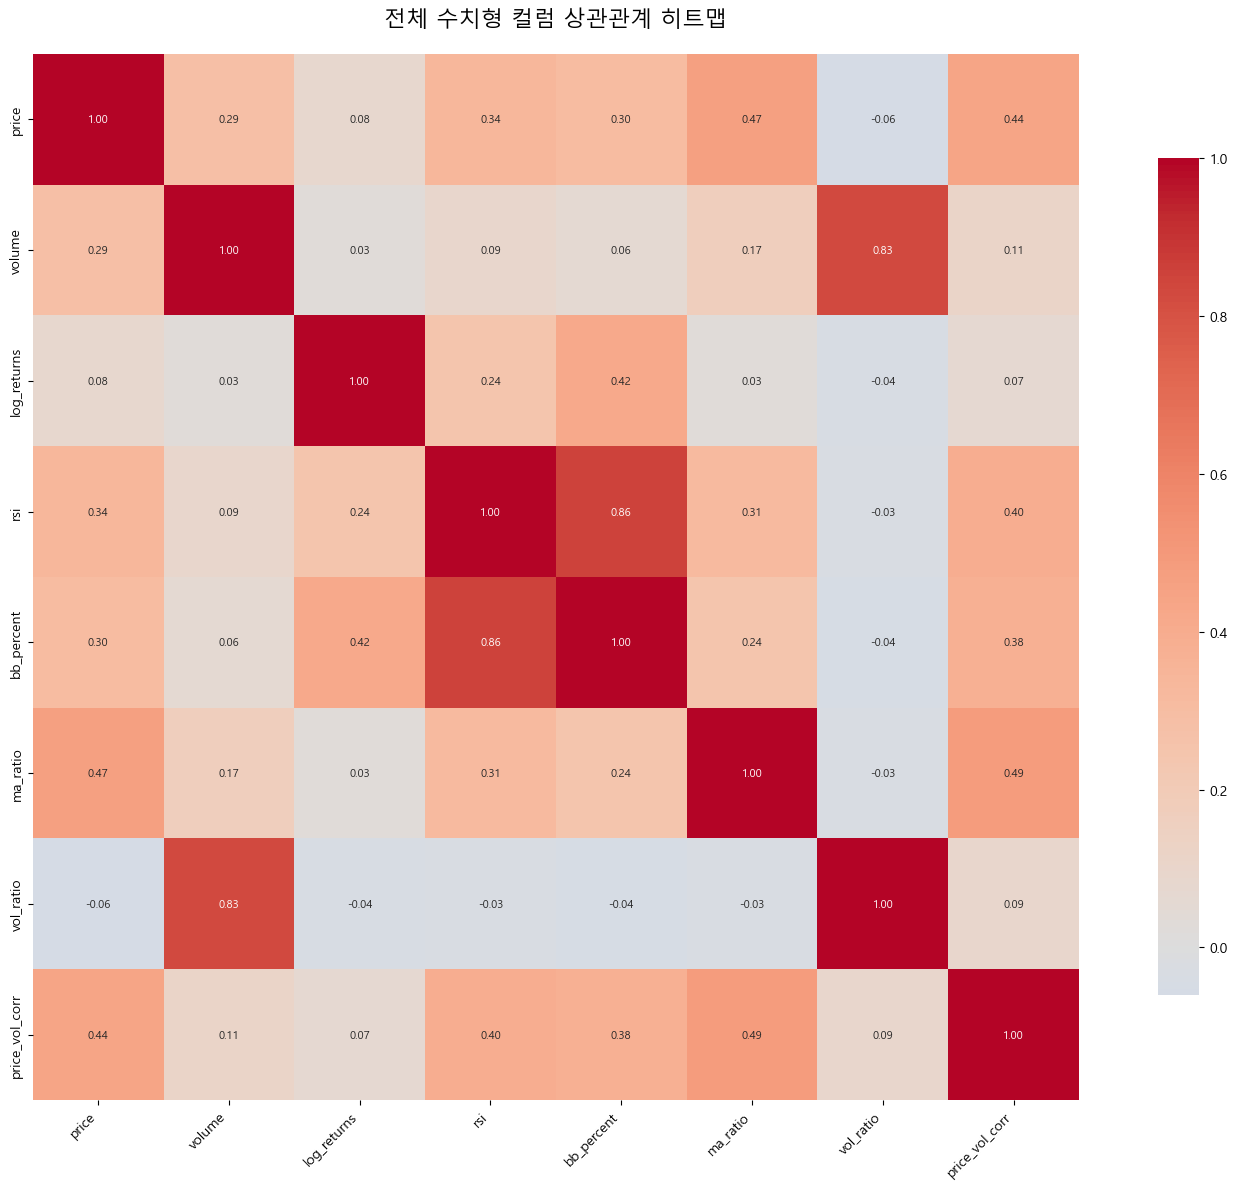

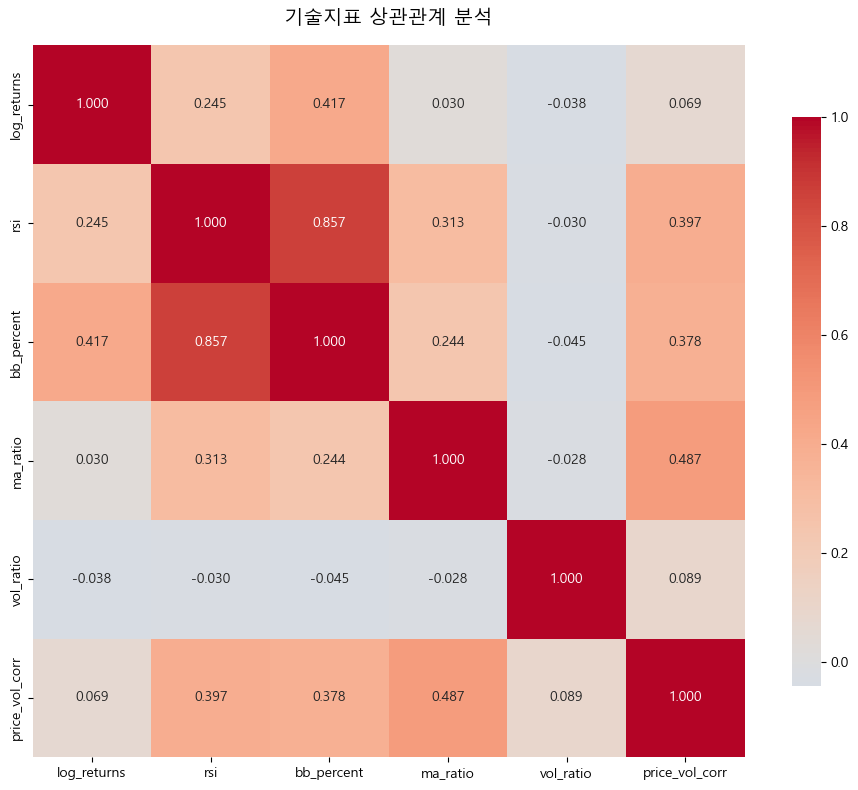

강한 상관관계 (|상관계수| >= 0.7):
 1. 양의 rsi <-> bb_percent: 0.857
 2. 양의 volume <-> vol_ratio: 0.833

모델 성능:
MSE: 0.000537
MAE: 0.017009
R²: -0.6614
RMSE: 0.023179

특성 중요도:
price_vol_corr: 0.245
vol_ratio: 0.213
bb_percent: 0.197
ma_ratio: 0.177
rsi: 0.168


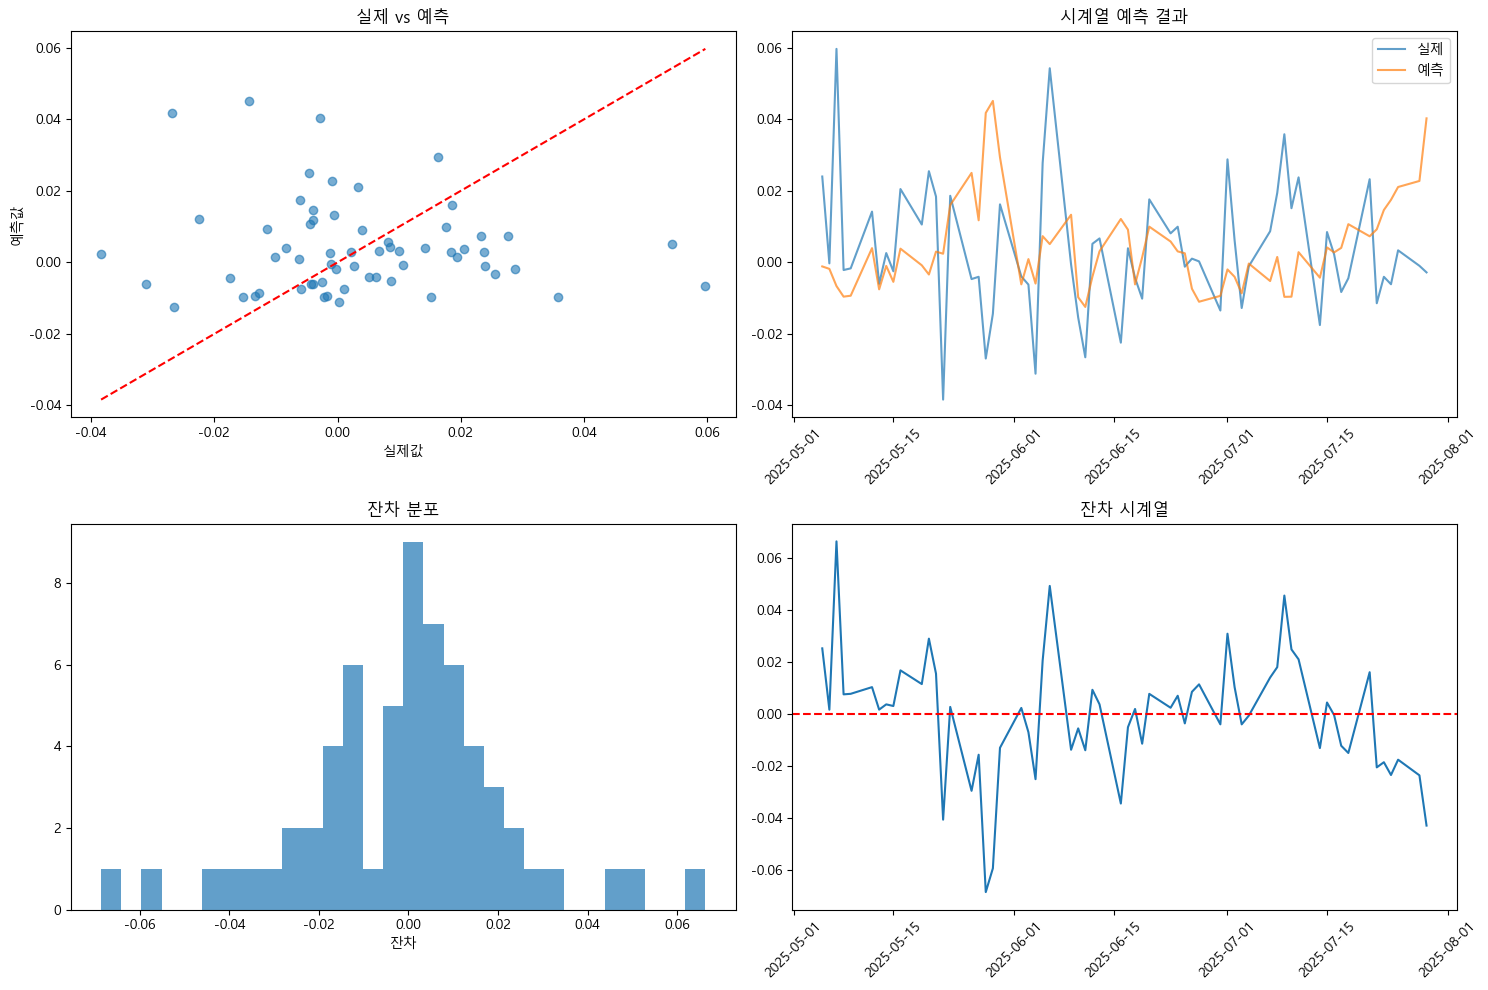


분석 완료
데이터 크기: 311행
분석 기간: 2024-05-21 ~ 2025-07-30
생성된 기술지표: 6개


In [123]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('merged_data_features.csv')

if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df.iloc[:, 0])
else:
    df['date'] = pd.to_datetime(df['date'])

if 'btc_usd' not in df.columns and 'BTC_EUR' in df.columns and 'USD_EUR' in df.columns:
    df['btc_usd'] = df['BTC_EUR'] / df['USD_EUR']

price_col = 'btc_usd' if 'btc_usd' in df.columns else 'price'
volume_cols = [col for col in df.columns if 'volume' in col.lower()]
volume_col = volume_cols[0] if volume_cols else None

technical_indicators = ['log_returns', 'rsi', 'bb_percent', 'ma_ratio', 'vol_ratio', 'price_vol_corr']

if 'log_returns' not in df.columns:
    df['log_returns'] = np.log(df[price_col] / df[price_col].shift(1))

if 'rsi' not in df.columns:
    delta = df[price_col].diff()
    gain = delta.where(delta > 0, 0).rolling(14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
    rs = gain / loss
    df['rsi'] = 100 - (100 / (1 + rs))

if 'bb_percent' not in df.columns:
    ma = df[price_col].rolling(20).mean()
    std = df[price_col].rolling(20).std()
    upper = ma + (2 * std)
    lower = ma - (2 * std)
    df['bb_percent'] = (df[price_col] - lower) / (upper - lower)

if 'ma_ratio' not in df.columns:
    ma_20 = df[price_col].rolling(20).mean()
    ma_50 = df[price_col].rolling(50).mean()
    df['ma_ratio'] = ma_20 / ma_50

if 'vol_ratio' not in df.columns and volume_col:
    vol_ma = df[volume_col].rolling(20).mean()
    df['vol_ratio'] = df[volume_col] / vol_ma

if 'price_vol_corr' not in df.columns and volume_col:
    df['price_vol_corr'] = df[price_col].rolling(20).corr(df[volume_col])

df.to_csv('merged_data_features.csv', index=False)

df = df.dropna(subset=['log_returns'])

fill_values = {
    'rsi': 50,
    'bb_percent': 0.5,
    'ma_ratio': 1.0,
    'vol_ratio': 1.0,
    'price_vol_corr': 0.0
}

for col, fill_val in fill_values.items():
    if col in df.columns:
        df[col] = df[col].fillna(fill_val)

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
exclude_cols = ['Unnamed: 0', 'index']
numeric_cols = [col for col in numeric_cols if col not in exclude_cols]

corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(16, 12))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, 
            annot=True, 
            cmap='coolwarm', 
            center=0,
            square=True,
            fmt='.2f',
            cbar_kws={"shrink": .8},
            annot_kws={'size': 8})

plt.title('전체 수치형 컬럼 상관관계 히트맵', fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('correlation_heatmap_full.png', dpi=300, bbox_inches='tight')
plt.show()

available_indicators = [col for col in technical_indicators if col in df.columns]
if len(available_indicators) >= 2:
    tech_corr = df[available_indicators].corr()
    
    plt.figure(figsize=(10, 8))
    mask = np.triu(np.ones_like(tech_corr, dtype=bool))
    sns.heatmap(tech_corr,
                annot=True,
                cmap='coolwarm',
                center=0,
                square=True,
                fmt='.3f',
                cbar_kws={"shrink": .8})
    
    plt.title('기술지표 상관관계 분석', fontsize=14, pad=15)
    plt.tight_layout()
    plt.savefig('technical_indicators_correlation.png', dpi=300, bbox_inches='tight')
    plt.show()

strong_pairs = []
n = len(corr_matrix.columns)

for i in range(n):
    for j in range(i+1, n):
        corr_val = corr_matrix.iloc[i, j]
        if abs(corr_val) >= 0.7:
            strong_pairs.append({
                'var1': corr_matrix.columns[i],
                'var2': corr_matrix.columns[j],
                'correlation': corr_val
            })

strong_pairs.sort(key=lambda x: abs(x['correlation']), reverse=True)

print("강한 상관관계 (|상관계수| >= 0.7):")
for i, pair in enumerate(strong_pairs[:15], 1):
    direction = "양의" if pair['correlation'] > 0 else "음의"
    print(f"{i:2d}. {direction} {pair['var1']} <-> {pair['var2']}: {pair['correlation']:.3f}")

feature_cols = [col for col in technical_indicators if col in df.columns and col != 'log_returns']
df['target'] = df['log_returns'].shift(-1)

clean_data = df.dropna()
X = clean_data[feature_cols]
y = clean_data['target']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

split_idx = int(len(X_scaled) * 0.8)
X_train, X_test = X_scaled[:split_idx], X_scaled[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\n모델 성능:")
print(f"MSE: {mse:.6f}")
print(f"MAE: {mae:.6f}")
print(f"R²: {r2:.4f}")
print(f"RMSE: {np.sqrt(mse):.6f}")

importance = model.feature_importances_
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': importance
}).sort_values('importance', ascending=False)

print(f"\n특성 중요도:")
for _, row in feature_importance.iterrows():
    print(f"{row['feature']}: {row['importance']:.3f}")

dates = clean_data.iloc[split_idx:]['date']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0,0].scatter(y_test, y_pred, alpha=0.6)
axes[0,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
axes[0,0].set_xlabel('실제값')
axes[0,0].set_ylabel('예측값')
axes[0,0].set_title('실제 vs 예측')

axes[0,1].plot(dates, y_test.values, label='실제', alpha=0.7)
axes[0,1].plot(dates, y_pred, label='예측', alpha=0.7)
axes[0,1].set_title('시계열 예측 결과')
axes[0,1].legend()
axes[0,1].tick_params(axis='x', rotation=45)

residuals = y_test.values - y_pred
axes[1,0].hist(residuals, bins=30, alpha=0.7)
axes[1,0].set_title('잔차 분포')
axes[1,0].set_xlabel('잔차')

axes[1,1].plot(dates, residuals)
axes[1,1].axhline(y=0, color='r', linestyle='--')
axes[1,1].set_title('잔차 시계열')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('prediction_results.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n분석 완료")
print(f"데이터 크기: {len(df):,}행")
print(f"분석 기간: {df['date'].min().strftime('%Y-%m-%d')} ~ {df['date'].max().strftime('%Y-%m-%d')}")
print(f"생성된 기술지표: {len(available_indicators)}개")

if 'btc_usd' in df.columns:
    price_stats = df['btc_usd'].describe()
    print(f"BTC/USD 평균: ${price_stats['mean']:,.2f}")
    print(f"BTC/USD 최고: ${price_stats['max']:,.2f}")
    print(f"BTC/USD 최저: ${price_stats['min']:,.2f}")